In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)


In [28]:
df = pd.read_csv('../data/processed/clean-dataset.csv')
df.head()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,education_level
0,173460,52.0,5668.0,24000.0,5000.0,São Paulo,SP,900.0,0.0,0,...,2011.0,1.0,0.0,0.0,search,4028XXXX,/emprestimos/solicitar,PersonalLoan,female,Ensino Médio Completo
1,173455,20.0,5000.0,14200.0,5000.0,Guarulhos,SP,1500.0,0.0,0,...,2004.0,1.0,0.0,0.0,direct,7060XXXX,/emprestimos,Unknown,male,Ensino Médio Completo
2,173450,48.0,3000.0,17000.0,8000.0,Manaus,AM,1060.0,0.0,0,...,2010.0,1.0,0.0,0.0,affiliates,6906XXXX,/emprestimos/garantia-veiculo/solicitar,Unknown,male,Superior Completo
3,173442,56.0,7500.0,21000.0,12000.0,Maracás,BA,0.0,1.0,0,...,2012.0,1.0,0.0,0.0,social,4536XXXX,/emprestimos/solicitar,PersonalLoan,male,Unknown
4,173437,35.0,3379.0,16500.0,5000.0,Itaquaquecetuba,SP,0.0,0.0,0,...,2008.0,1.0,0.0,0.0,search,8588XXXX,/emprestimos/solicitar,PersonalLoan,male,Ensino Médio Completo


In [29]:
TARGET = 'sent_to_analysis'
y = df[TARGET]
X = df.drop(columns=[TARGET, 'id', 'pre_approved']) 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,      
    random_state=42,    
    stratify=y
)

In [31]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\n{len(numeric_features)} features numéricas.")
print(f"{len(categorical_features)} features categóricas.")


15 features numéricas.
11 features categóricas.


In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [33]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) 
])

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)

In [35]:
logreg_model = LogisticRegression(
    class_weight='balanced', 
    random_state=42, 
    max_iter=2000,
    solver='liblinear' 
)

In [36]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg_model)
])

In [37]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'collateral_value',
                                                   'loan_amount',
                                                   'collateral_debt',
                                                   'verified_restriction',
                                                   'dishonored_checks',
                                                   'expired_debts',
                                                   'banking_debts',
                                                   'commercial_de...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['city', 'state',
                                                   'informed_purpose',
                                                   'auto_brand', 'auto_model',
                                                   'channel', 'zip_code',
                                                   'landing_page',
                                                   'landing_page_product',
                                                   'gender',
                                                   'education_level'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42, solver='liblinear'))])

In [38]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

/home/nagah/workspace/creditas-case/venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/nagah/workspace/creditas-case/venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81      2933
         1.0       0.40      0.59      0.48       817

    accuracy                           0.72      3750
   macro avg       0.64      0.67      0.64      3750
weighted avg       0.77      0.72      0.74      3750



In [40]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC no conjunto de teste: {auc_score:.4f}")

AUC no conjunto de teste: 0.7550


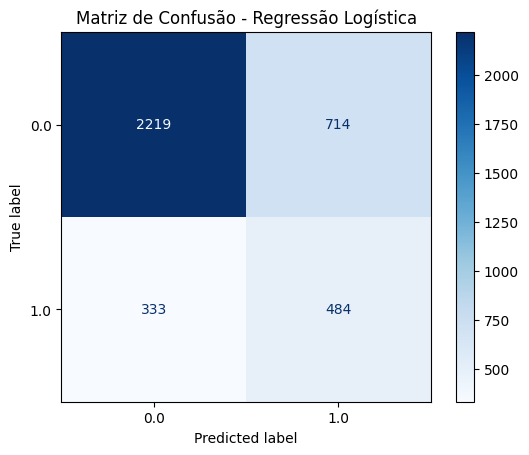

In [41]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

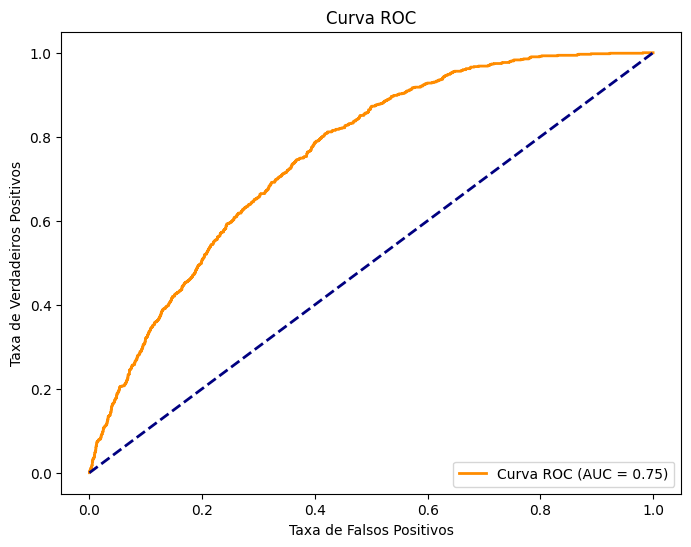

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

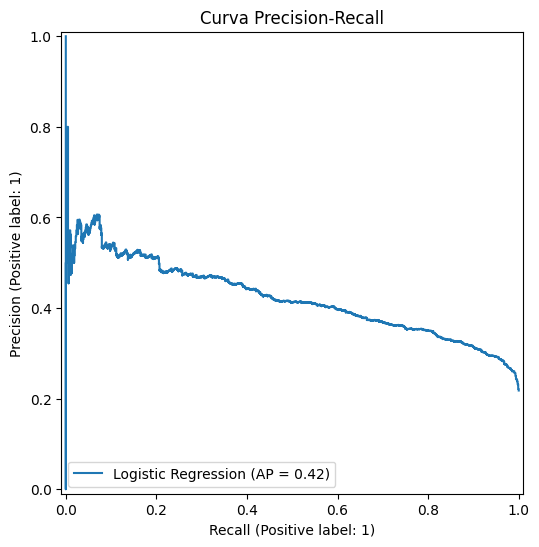

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=ax, name="Logistic Regression")
plt.title('Curva Precision-Recall')
plt.show()

In [44]:
import pickle

filename = '../models/modelo_reglog.pkl'

with open(filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f"\nModelo salvo com sucesso no arquivo: {filename}")


Modelo salvo com sucesso no arquivo: ../models/modelo_reglog.pkl
